State space time series modeling with statsmodels.

- Local Level Model
- 2nd Order Trend Model
- Local Level + Seasonality Model

**References:**

- statsmodels documentations
    - https://www.statsmodels.org/stable/examples/notebooks/generated/statespace_structural_harvey_jaeger.html
    - https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.structural.UnobservedComponents.html
    - https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.structural.UnobservedComponentsResults.html
    
- Local Level Model, 2nd Order Trend Model
    - [馬場真哉、実践Data Scienceシリーズ　RとStanではじめる　ベイズ統計モデリングによるデータ分析入門 (ＫＳ情報科学専門書)、講談社(2019)](https://www.amazon.co.jp/dp/B07WFD5RFS/ref=cm_sw_r_tw_dp_x_zWU6Fb5BSEM8M)
- Local Level + Seasonality Model
    - [松浦健太郎, Stan入門 ― 次世代のベイジアンモデリングツール in 岩波データサイエンス Vol.1、岩波書店(2015)](https://www.amazon.co.jp/dp/4000298518/ref=cm_sw_r_tw_dp_x_ZUU6FbWE32YDC)
    - [伊東宏樹、Ｒによる状態空間モデリング in 岩波データサイエンス Vol.6、岩波書店(2017)](https://www.amazon.co.jp/dp/4000298569/ref=cm_sw_r_tw_dp_x_WZU6FbBB04HB3)

In [1]:
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
import japanize_matplotlib
%matplotlib inline

In [23]:
from scipy.stats import norm
import numpy as np

In [24]:
critical_value80 = norm.ppf(1 - 0.20 / 2.)
critical_value50 = norm.ppf(1 - 0.50 / 2.)

# Local Level Model

$$
\begin{aligned}
\end{aligned}
\begin{aligned}
y_t &= \alpha_t + \varepsilon_t, \quad \varepsilon_t \sim N(0, \sigma_\varepsilon^2)\\
\alpha_{t+1} &= \alpha_t + \eta_t, \quad \eta_t \sim N(0,\sigma_\eta^2)
\end{aligned}
$$

In [2]:
# https://github.com/logics-of-blue/book-r-stan-bayesian-model-intro/blob/master/book-data/5-5-1-sales-ts-3.csv
df_sales = pd.read_csv('../data/5-5-1-sales-ts-3.csv')
df_sales['date'] = pd.to_datetime(df_sales['date'])
df_sales = df_sales.set_index('date').asfreq('D')

In [3]:
df_sales.head()

,sales
date,
2010-01-01,93.5
2010-01-02,81.9
2010-01-03,91.0
2010-01-04,91.2
2010-01-05,102.5


<AxesSubplot:xlabel='date'>

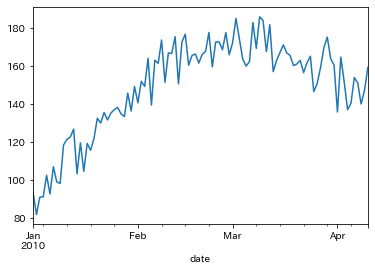

In [4]:
df_sales['sales'].plot()

In [19]:
llevel_model = sm.tsa.UnobservedComponents(df_sales['sales'], level='local level', use_exact_diffuse=True)

In [20]:
llevel_results = llevel_model.fit(method='bfgs')

Optimization terminated successfully.
         Current function value: 3.673384
         Iterations: 14
         Function evaluations: 23
         Gradient evaluations: 23


In [21]:
llevel_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Unobserved Components Results                         
==============================================================================
Dep. Variable:                  sales   No. Observations:                  100
Model:                    local level   Log Likelihood                -367.338
Date:                Sat, 30 Jan 2021   AIC                            740.677
Time:                        15:18:58   BIC                            748.492
Sample:                    01-01-2010   HQIC                           743.840
                         - 04-10-2010                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular    56.8631     11.168      5.092      0.000      34.975      78.751
sigma2.level        15.6958      6.844      2.293      0.022       2.282      29.109
===================================================================================
Ljung-Box (L1) (Q):                   0.93   Jarque-Bera (JB):                 3.70
Prob(Q):                              0.33   Prob(JB):                         0.16
Heteroskedasticity (H):               1.34   Skew:                            -0.47
Prob(H) (two-sided):                  0.41   Kurtosis:                         2.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

`plot_components`メソッドを使うことで、

- 観測値と一期先予測値
- 各成分の平滑化推定量

を表示することができる。

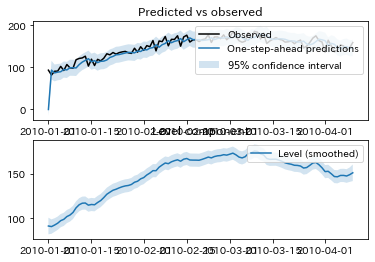

In [22]:
fig = llevel_results.plot_components(which='smoothed')

## Level + Noise

In [202]:
llevel_smoothed_pred_mean = pd.concat([pd.Series(llevel_results.filter_results.smoothed_forecasts[0], index=df_sales.index), llevel_forecast.predicted_mean])

llevel_smoothed_pred_std = pd.concat([pd.Series(
    np.sqrt(llevel_results.filter_results.smoothed_forecasts_error_cov[0, 0]), 
    index=df_sales.index),
    np.sqrt(llevel_forecast.var_pred_mean)])

In [203]:
llevel_smoothed_pred_mean.name='alphahat'
llevel_smoothed_pred_std.name = 'std_alpha'

df_llevel_results = df_sales.copy()
df_llevel_results = df_llevel_results.join(llevel_smoothed_pred_mean, how='outer').join(llevel_smoothed_pred_std, how='outer')

df_llevel_results['lower10'] = df_llevel_results['alphahat'] - critical_value80 * df_llevel_results['std_alpha']
df_llevel_results['lower25'] = df_llevel_results['alphahat'] - critical_value50 * df_llevel_results['std_alpha']
df_llevel_results['upper25'] = df_llevel_results['alphahat'] + critical_value50 * df_llevel_results['std_alpha']
df_llevel_results['upper10'] = df_llevel_results['alphahat'] + critical_value80 * df_llevel_results['std_alpha']

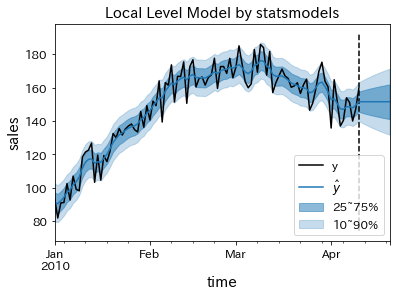

In [204]:
ax = df_llevel_results['sales'].plot(color='black', label='y')
ax = df_llevel_results['alphahat'].plot(color='tab:blue', ax=ax, label='$\\hat{y}$')
ax.fill_between(df_llevel_results.index, df_llevel_results['lower25'], df_llevel_results['upper25'], alpha=0.5, color='tab:blue', label='25~75%')
ax.fill_between(df_llevel_results.index, df_llevel_results['lower10'], df_llevel_results['upper10'], alpha=0.25, color='tab:blue', label='10~90%')
ax.vlines(df_sales.index.max(), *ax.get_ylim(), linestyle='dashed', color='black')

ax.set_xlabel('time', fontsize=15)
ax.set_ylabel('sales', fontsize=15)
ax.set_title('Local Level Model by statsmodels', fontsize=15)
ax.tick_params(labelsize=12)

ax.legend(fontsize=12)

## Level

In [29]:
llevel_forecast_level_mean = llevel_forecast.prediction_results.results.predicted_state[0, :-1]
llevel_forecast_level_std = np.sqrt(llevel_forecast.prediction_results.results.predicted_state_cov[0, 0, :-1])

In [30]:
df_llevel_level = pd.DataFrame([], index=df_llevel_results.index)

df_llevel_level['mean'] = np.hstack([llevel_results.level['smoothed'], llevel_forecast_level_mean])
df_llevel_level['std'] = np.hstack([np.sqrt(llevel_results.level['smoothed_cov']), llevel_forecast_level_std])

In [31]:
df_llevel_level['lower10'] = df_llevel_level['mean'] - critical_value80 * df_llevel_level['std']
df_llevel_level['lower25'] = df_llevel_level['mean'] - critical_value50 * df_llevel_level['std']
df_llevel_level['upper25'] = df_llevel_level['mean'] + critical_value50 * df_llevel_level['std']
df_llevel_level['upper10'] = df_llevel_level['mean'] + critical_value80 * df_llevel_level['std']

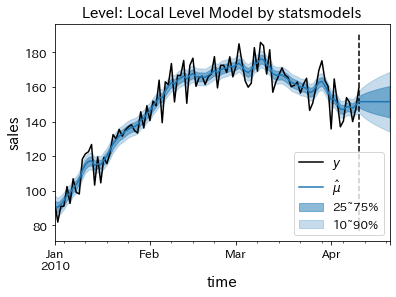

In [32]:
ax = df_sales['sales'].plot(color='black', label='$y$')
ax = df_llevel_level['mean'].plot(color='tab:blue', ax=ax, label='$\\hat{\\mu}$')
ax.fill_between(df_llevel_level.index, df_llevel_level['lower25'], df_llevel_level['upper25'], alpha=0.5, color='tab:blue', label='25~75%')
ax.fill_between(df_llevel_level.index, df_llevel_level['lower10'], df_llevel_level['upper10'], alpha=0.25, color='tab:blue', label='10~90%')
ax.vlines(df_sales.index.max(), *ax.get_ylim(), linestyle='dashed', color='black')

ax.set_xlabel('time', fontsize=15)
ax.set_ylabel('sales', fontsize=15)
ax.set_title('Level: Local Level Model by statsmodels', fontsize=15)
ax.tick_params(labelsize=12)

ax.legend(fontsize=12)

# 2nd Order Trend Model (Smooth Trend Model)


$$
\begin{aligned}
\end{aligned}
\begin{aligned}
y_t &= \mu_t^{(1)} + \varepsilon_t, \quad \varepsilon_t \sim N(0, \sigma_\varepsilon^2)\\
\mu_{t+1}^{(1)} &= \mu_t^{(1)} + \mu_t^{(2)}\\
\mu_{t+1}^{(2)} &= \mu_t^{(2)} + \eta_t, \quad \eta_t \sim N(0,\sigma_\eta^2)\\
(\Delta^2\mu_{t+2}^{(1)} &\equiv \mu_{t+2}^{(1)} - 2 \mu_{t+1}^{(1)} + \mu_{t}^{(1)} = \eta_t)
\end{aligned}
$$

In [35]:
strend_model = sm.tsa.UnobservedComponents(df_sales['sales'], level='smooth trend', use_exact_diffuse=True)

In [36]:
strend_results = strend_model.fit(method='bfgs')

Optimization terminated successfully.
         Current function value: 3.620926
         Iterations: 21
         Function evaluations: 35
         Gradient evaluations: 35


In [37]:
strend_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Unobserved Components Results                         
==============================================================================
Dep. Variable:                  sales   No. Observations:                  100
Model:                   smooth trend   Log Likelihood                -362.093
Date:                Sat, 30 Jan 2021   AIC                            732.185
Time:                        15:19:20   BIC                            742.606
Sample:                    01-01-2010   HQIC                           736.403
                         - 04-10-2010                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular    69.3305     10.241      6.770      0.000      49.258      89.403
sigma2.trend         0.0372      0.039      0.949      0.342      -0.040       0.114
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 1.47
Prob(Q):                              0.90   Prob(JB):                         0.48
Heteroskedasticity (H):               1.64   Skew:                            -0.26
Prob(H) (two-sided):                  0.16   Kurtosis:                         2.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

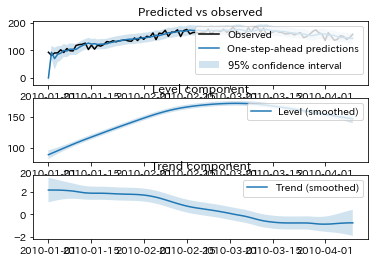

In [38]:
fig = strend_results.plot_components(which='smoothed')

## Level + Noise

In [39]:
strend_forecast = strend_results.get_forecast(steps=10)

In [236]:
strend_smoothed_pred_mean = pd.concat([pd.Series(strend_results.filter_results.smoothed_forecasts[0], index=df_sales.index), strend_forecast.predicted_mean])

strend_smoothed_pred_std = pd.concat([pd.Series(
    np.sqrt(strend_results.filter_results.smoothed_forecasts_error_cov[0,0]), 
    index=df_sales.index),
    np.sqrt(strend_forecast.var_pred_mean)])

In [237]:
strend_smoothed_pred_mean.name='alphahat'
strend_smoothed_pred_std.name = 'std_alpha'

df_strend_results = df_sales.copy()
df_strend_results = df_strend_results.join(strend_smoothed_pred_mean, how='outer').join(strend_smoothed_pred_std, how='outer')

df_strend_results['lower10'] = df_strend_results['alphahat'] - critical_value80 * df_strend_results['std_alpha']
df_strend_results['lower25'] = df_strend_results['alphahat'] - critical_value50 * df_strend_results['std_alpha']
df_strend_results['upper25'] = df_strend_results['alphahat'] + critical_value50 * df_strend_results['std_alpha']
df_strend_results['upper10'] = df_strend_results['alphahat'] + critical_value80 * df_strend_results['std_alpha']

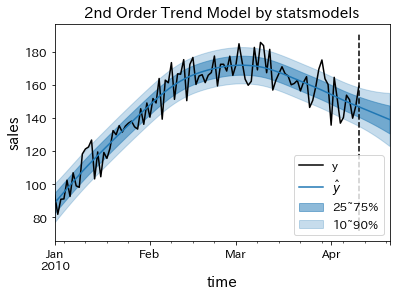

In [238]:
ax = df_strend_results['sales'].plot(color='black', label='y')
ax = df_strend_results['alphahat'].plot(color='tab:blue', ax=ax, label='$\\hat{y}$')
ax.fill_between(df_strend_results.index, df_strend_results['lower25'], df_strend_results['upper25'], alpha=0.5, color='tab:blue', label='25~75%')
ax.fill_between(df_strend_results.index, df_strend_results['lower10'], df_strend_results['upper10'], alpha=0.25, color='tab:blue', label='10~90%')
ax.vlines(df_sales.index.max(), *ax.get_ylim(), linestyle='dashed', color='black')

ax.set_xlabel('time', fontsize=15)
ax.set_ylabel('sales', fontsize=15)
ax.set_title('2nd Order Trend Model by statsmodels', fontsize=15)
ax.tick_params(labelsize=12)

ax.legend(fontsize=12)

## Level

In [43]:
strend_forecast_level_mean = strend_forecast.prediction_results.results.predicted_state[0, :-1]
strend_forecast_level_std = np.sqrt(strend_forecast.prediction_results.results.predicted_state_cov[0, 0, :-1])

In [44]:
df_strend_level = pd.DataFrame([], index=df_strend_results.index)

df_strend_level['mean'] = np.hstack([strend_results.level['smoothed'], strend_forecast_level_mean])
df_strend_level['std'] = np.hstack([np.sqrt(strend_results.level['smoothed_cov']), strend_forecast_level_std])

In [45]:
df_strend_level['lower10'] = df_strend_level['mean'] - critical_value80 * df_strend_level['std']
df_strend_level['lower25'] = df_strend_level['mean'] - critical_value50 * df_strend_level['std']
df_strend_level['upper25'] = df_strend_level['mean'] + critical_value50 * df_strend_level['std']
df_strend_level['upper10'] = df_strend_level['mean'] + critical_value80 * df_strend_level['std']

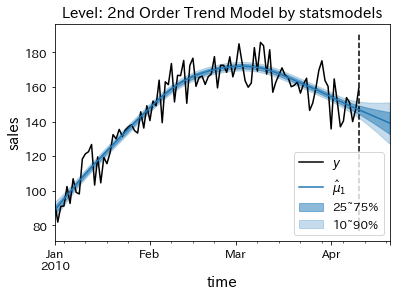

In [46]:
ax = df_sales['sales'].plot(color='black', label='$y$')
ax = df_strend_level['mean'].plot(color='tab:blue', ax=ax, label='$\\hat{\\mu}_1$')
ax.fill_between(df_strend_level.index, df_strend_level['lower25'], df_strend_level['upper25'], alpha=0.5, color='tab:blue', label='25~75%')
ax.fill_between(df_strend_level.index, df_strend_level['lower10'], df_strend_level['upper10'], alpha=0.25, color='tab:blue', label='10~90%')
ax.vlines(df_sales.index.max(), *ax.get_ylim(), linestyle='dashed', color='black')

ax.set_xlabel('time', fontsize=15)
ax.set_ylabel('sales', fontsize=15)
ax.set_title('Level: 2nd Order Trend Model by statsmodels', fontsize=15)
ax.tick_params(labelsize=12)

ax.legend(fontsize=12)

## Trend Diff

In [47]:
strend_forecast_trend_mean = strend_forecast.prediction_results.results.predicted_state[1, :-1]
strend_forecast_trend_std = np.sqrt(strend_forecast.prediction_results.results.predicted_state_cov[1, 1, :-1])

In [48]:
df_strend_trend = pd.DataFrame([], index=df_strend_results.index)

df_strend_trend['mean'] = np.hstack([strend_results.trend['smoothed'], strend_forecast_trend_mean])
df_strend_trend['std'] = np.hstack([np.sqrt(strend_results.trend['smoothed_cov']), strend_forecast_trend_std])

In [49]:
df_strend_trend['lower10'] = df_strend_trend['mean'] - critical_value80 * df_strend_trend['std']
df_strend_trend['lower25'] = df_strend_trend['mean'] - critical_value50 * df_strend_trend['std']
df_strend_trend['upper25'] = df_strend_trend['mean'] + critical_value50 * df_strend_trend['std']
df_strend_trend['upper10'] = df_strend_trend['mean'] + critical_value80 * df_strend_trend['std']

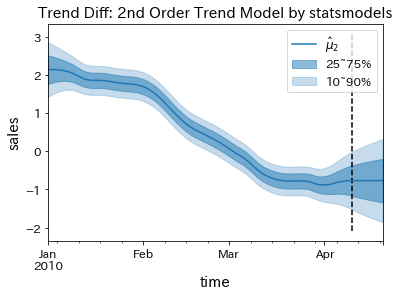

In [50]:
ax = df_strend_trend['mean'].plot(color='tab:blue', label='$\\hat{\\mu}_2$')
ax.fill_between(df_strend_trend.index, df_strend_trend['lower25'], df_strend_trend['upper25'], alpha=0.5, color='tab:blue', label='25~75%')
ax.fill_between(df_strend_trend.index, df_strend_trend['lower10'], df_strend_trend['upper10'], alpha=0.25, color='tab:blue', label='10~90%')
ax.vlines(df_sales.index.max(), *ax.get_ylim(), linestyle='dashed', color='black')

ax.set_xlabel('time', fontsize=15)
ax.set_ylabel('sales', fontsize=15)
ax.set_title('Trend Diff: 2nd Order Trend Model by statsmodels', fontsize=15)
ax.tick_params(labelsize=12)

ax.legend(fontsize=12)

# Local Level + Seasonality Model
$$
\begin{aligned}
\end{aligned}
\begin{aligned}
y_t &= \mu_t + \gamma_t + \varepsilon_t, \quad \varepsilon_t \sim N(0, \sigma_\varepsilon^2)\\
\mu_{t+1} &= \mu_t + \eta^{(\mu)}_t, \quad \eta^{(\mu)}_t \sim N(0, \sigma_{\mu}^2)\\ 
\gamma_{t+1} &= - \gamma_t - \gamma_{t-1} - \gamma_{t-2} + \eta^{(\gamma)}_t,\quad \eta^{(\gamma)}_t \sim N(0, \sigma_\gamma^2)
\end{aligned}
$$

In [51]:
# https://github.com/iwanami-datascience/vol1/matsuura/example2/input/data-season.txt
df_seasonal_sales = pd.read_csv('../data/data-season.txt')
df_seasonal_sales = df_seasonal_sales.rename(columns={'Y': 'sales'})

In [52]:
df_seasonal_sales.head()

,sales
0,18.073
1,23.665
2,16.410
3,14.931
4,17.106


<AxesSubplot:>

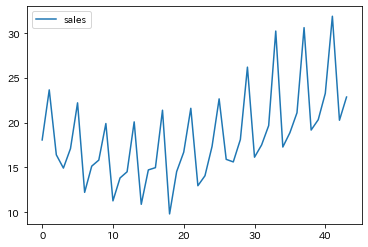

In [53]:
df_seasonal_sales.plot()

In [55]:
seasonal_model = sm.tsa.UnobservedComponents(df_seasonal_sales['sales'], level='local level', seasonal=4, use_exact_diffuse=True)

In [56]:
seasonal_results = seasonal_model.fit(method='bfgs')

Optimization terminated successfully.
         Current function value: 1.741845
         Iterations: 11
         Function evaluations: 21
         Gradient evaluations: 21


In [57]:
seasonal_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Unobserved Components Results                            
====================================================================================
Dep. Variable:                        sales   No. Observations:                   44
Model:                          local level   Log Likelihood                 -76.641
                   + stochastic seasonal(4)   AIC                            167.282
Date:                      Sat, 30 Jan 2021   BIC                            179.772
Time:                              15:20:04   HQIC                           171.914
Sample:                                   0                                         
                                       - 44                                         
Covariance Type:                        opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular  7.543e-12      0.370   2.04e-11      1.000      -0.726       0.726
sigma2.level         0.4470      0.208      2.149      0.032       0.039       0.855
sigma2.seasonal      0.4115      0.209      1.967      0.049       0.002       0.821
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 0.51
Prob(Q):                              0.78   Prob(JB):                         0.77
Heteroskedasticity (H):               1.02   Skew:                            -0.08
Prob(H) (two-sided):                  0.97   Kurtosis:                         3.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

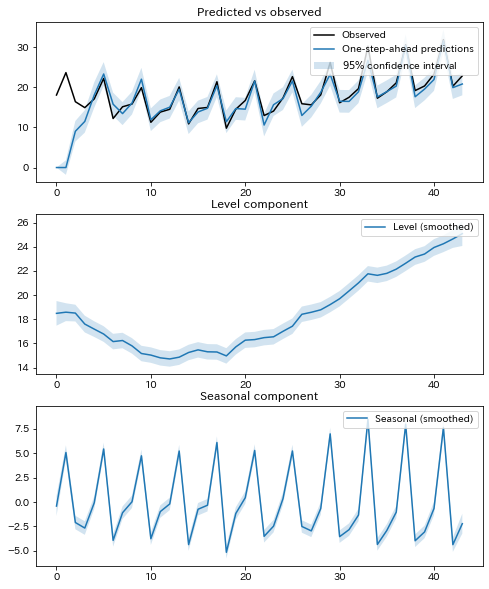

In [244]:
fig = seasonal_results.plot_components(which='smoothed', figsize=(8, 10))

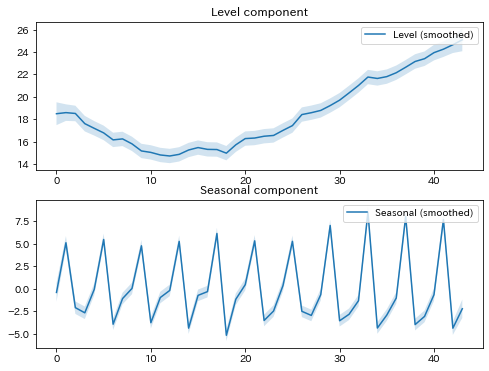

In [220]:
fig = seasonal_results.plot_components(which='smoothed', seasonal=True, observed=False, figsize=(8, 6))

## Level+Seasonality+Noise

In [233]:
seasonal_smoothed_pred_mean = pd.concat([pd.Series(seasonal_results.filter_results.smoothed_forecasts[0], index=df_seasonal_sales.index), seasonal_forecast.predicted_mean])

seasonal_smoothed_pred_std = pd.concat([pd.Series(
    np.sqrt(seasonal_results.filter_results.smoothed_forecasts_error_cov[0,0]), 
    index=df_seasonal_sales.index),
    np.sqrt(seasonal_forecast.var_pred_mean)])

In [234]:
seasonal_smoothed_pred_mean.name='alphahat'
seasonal_smoothed_pred_std.name = 'std_alpha'

df_seasonal_results = df_seasonal_sales.copy()
df_seasonal_results = df_seasonal_results.join(seasonal_smoothed_pred_mean, how='outer').join(seasonal_smoothed_pred_std, how='outer')

df_seasonal_results['lower10'] = df_seasonal_results['alphahat'] - critical_value80 * df_seasonal_results['std_alpha']
df_seasonal_results['lower25'] = df_seasonal_results['alphahat'] - critical_value50 * df_seasonal_results['std_alpha']
df_seasonal_results['upper25'] = df_seasonal_results['alphahat'] + critical_value50 * df_seasonal_results['std_alpha']
df_seasonal_results['upper10'] = df_seasonal_results['alphahat'] + critical_value80 * df_seasonal_results['std_alpha']

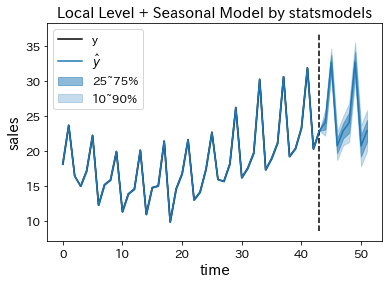

In [235]:
ax = df_seasonal_results['sales'].plot(color='black', label='y')
ax = df_seasonal_results['alphahat'].plot(color='tab:blue', ax=ax, label='$\\hat{y}$')
ax.fill_between(df_seasonal_results.index, df_seasonal_results['lower25'], df_seasonal_results['upper25'], alpha=0.5, color='tab:blue', label='25~75%')
ax.fill_between(df_seasonal_results.index, df_seasonal_results['lower10'], df_seasonal_results['upper10'], alpha=0.25, color='tab:blue', label='10~90%')
ax.vlines(df_seasonal_sales.index.max(), *ax.get_ylim(), linestyle='dashed', color='black')

ax.set_xlabel('time', fontsize=15)
ax.set_ylabel('sales', fontsize=15)
ax.set_title('Local Level + Seasonal Model by statsmodels', fontsize=15)
ax.tick_params(labelsize=12)

ax.legend(fontsize=12)

## Level

In [63]:
df_level = pd.DataFrame([], index=df_seasonal_results.index)

df_level['mean'] = np.hstack([seasonal_results.level['smoothed'], seasonal_forecast.prediction_results.results.predicted_state[0][:-1]])
df_level['std'] = np.sqrt(np.hstack([seasonal_results.level['smoothed_cov'], seasonal_forecast.prediction_results.results.predicted_state_cov[0][0][:-1]]))

In [64]:
df_level['lower10'] = df_level['mean'] - critical_value80 * df_level['std']
df_level['lower25'] = df_level['mean'] - critical_value50 * df_level['std']
df_level['upper25'] = df_level['mean'] + critical_value50 * df_level['std']
df_level['upper10'] = df_level['mean'] + critical_value80 * df_level['std']

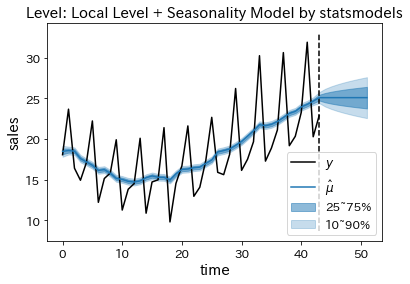

In [65]:
ax = df_seasonal_sales['sales'].plot(color='black', label='$y$')
ax = df_level['mean'].plot(color='tab:blue', ax=ax, label='$\\hat{\\mu}$')
ax.fill_between(df_level.index, df_level['lower25'], df_level['upper25'], alpha=0.5, color='tab:blue', label='25~75%')
ax.fill_between(df_level.index, df_level['lower10'], df_level['upper10'], alpha=0.25, color='tab:blue', label='10~90%')
ax.vlines(df_seasonal_sales.index.max(), *ax.get_ylim(), linestyle='dashed', color='black')

ax.set_xlabel('time', fontsize=15)
ax.set_ylabel('sales', fontsize=15)
ax.set_title('Level: Local Level + Seasonality Model by statsmodels', fontsize=15)
ax.tick_params(labelsize=12)

ax.legend(fontsize=12)

## Seasonality

In [66]:
df_seasonal = pd.DataFrame([], index=df_seasonal_results.index)

df_seasonal['mean'] = np.hstack([seasonal_results.seasonal['smoothed'], seasonal_forecast.prediction_results.results.predicted_state[1][:-1]])
df_seasonal['std'] = np.sqrt(np.hstack([seasonal_results.seasonal['smoothed_cov'], seasonal_forecast.prediction_results.results.predicted_state_cov[1][1][:-1]]))

In [67]:
df_seasonal['lower10'] = df_seasonal['mean'] - critical_value80 * df_seasonal['std']
df_seasonal['lower25'] = df_seasonal['mean'] - critical_value50 * df_seasonal['std']
df_seasonal['upper25'] = df_seasonal['mean'] + critical_value50 * df_seasonal['std']
df_seasonal['upper10'] = df_seasonal['mean'] + critical_value80 * df_seasonal['std']

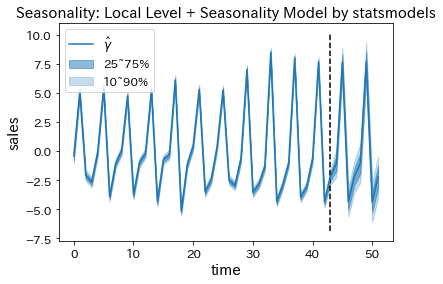

In [68]:
ax = df_seasonal['mean'].plot(color='tab:blue', label='$\\hat{\\gamma}$')
ax.fill_between(df_seasonal.index, df_seasonal['lower25'], df_seasonal['upper25'], alpha=0.5, color='tab:blue', label='25~75%')
ax.fill_between(df_seasonal.index, df_seasonal['lower10'], df_seasonal['upper10'], alpha=0.25, color='tab:blue', label='10~90%')
ax.vlines(df_seasonal_sales.index.max(), *ax.get_ylim(), linestyle='dashed', color='black')

ax.set_xlabel('time', fontsize=15)
ax.set_ylabel('sales', fontsize=15)
ax.set_title('Seasonality: Local Level + Seasonality Model by statsmodels', fontsize=15)
ax.tick_params(labelsize=12)

ax.legend(fontsize=12, loc='upper left')

## Level+Seasonality

In [69]:
df_lev_seas = pd.DataFrame([], index=df_seasonal_results.index)

df_lev_seas['mean'] = np.hstack([seasonal_results.level['smoothed'] + seasonal_results.seasonal['smoothed'],
                                 seasonal_forecast.prediction_results.results.predicted_state[0][:-1] + seasonal_forecast.prediction_results.results.predicted_state[1][:-1]])

df_lev_seas['std'] = np.sqrt(np.hstack([seasonal_results.filter_results.smoothed_state_cov[:2, :2].sum(0).sum(0), 
                                        seasonal_forecast.prediction_results.results.predicted_state_cov[:2, :2].sum(0).sum(0)[:-1]]))

In [70]:
df_lev_seas['lower10'] = df_lev_seas['mean'] - critical_value80 * df_lev_seas['std']
df_lev_seas['lower25'] = df_lev_seas['mean'] - critical_value50 * df_lev_seas['std']
df_lev_seas['upper25'] = df_lev_seas['mean'] + critical_value50 * df_lev_seas['std']
df_lev_seas['upper10'] = df_lev_seas['mean'] + critical_value80 * df_lev_seas['std']

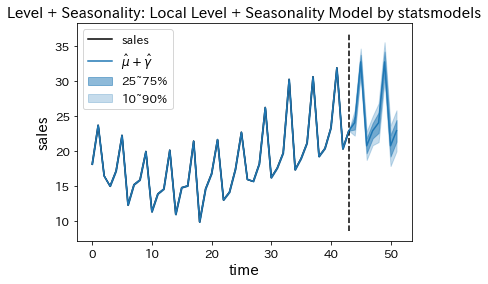

In [71]:
ax = df_seasonal_sales.plot(color='black')
ax = df_lev_seas['mean'].plot(color='tab:blue', ax=ax, label='$\\hat{\\mu} + \\hat{\\gamma}$')
ax.fill_between(df_lev_seas.index, df_lev_seas['lower25'], df_lev_seas['upper25'], alpha=0.5, color='tab:blue', label='25~75%')
ax.fill_between(df_lev_seas.index, df_lev_seas['lower10'], df_lev_seas['upper10'], alpha=0.25, color='tab:blue', label='10~90%')
ax.vlines(df_seasonal_sales.index.max(), *ax.get_ylim(), linestyle='dashed', color='black')

ax.set_xlabel('time', fontsize=15)
ax.set_ylabel('sales', fontsize=15)
ax.set_title('Level + Seasonality: Local Level + Seasonality Model by statsmodels', fontsize=15)
ax.tick_params(labelsize=12)

ax.legend(fontsize=12, loc='upper left')